In [1]:
import numpy as np  # Импорт библиотеки для работы с массивами
import matplotlib.pyplot as plt  # Импорт библиотеки для визуализации данных
import pandas as pd  # Импорт библиотеки для работы с данными в формате таблицы
import math  # Импорт математических функций
import tensorflow as tf  # Импорт библиотеки для создания и обучения моделей машинного обучения
from tensorflow.keras.models import Sequential  # Импорт модуля для создания последовательной модели
from tensorflow.keras.layers import Dense, LSTM  # Импорт слоев для построения модели
from sklearn.preprocessing import MinMaxScaler  # Импорт модуля для нормализации данных
from sklearn.metrics import mean_squared_error  # Импорт метрики для оценки ошибки предсказания

from google.colab import drive  # Импорт библиотеки для работы с Google Drive
drive.mount('/content/gdrive')  # Подключение к Google Drive

Mounted at /content/gdrive


In [2]:
# Установка seed для воспроизводимости результатов
tf.random.set_seed(7)

In [4]:
# Загрузка датасета
dataframe = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Time series/100.csv', usecols=[1], engine='python')  # Чтение данных из файла CSV, используя только второй столбец
dataset = dataframe.values  # Преобразование данных в массив NumPy
dataset = dataset.astype('float32')  # Приведение данных к типу float32

In [5]:
# Нормализация датасета
scaler = MinMaxScaler(feature_range=(0, 1))  # Создание объекта для нормализации в диапазоне [0, 1]
dataset = scaler.fit_transform(dataset)  # Применение нормализации к датасету

In [6]:
# Разделение на обучающий и тестовый наборы
sets_len = int(20000/0.67)  # Длина выборки
dataset = dataset[0:sets_len]  # Обрезка сигнала

train_size = int(len(dataset) * 0.67)  # Размер обучающей выборки (первые 67%)
test_size = len(dataset) - train_size  # Размер тестовой выборки (оставшиеся 33%)

train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]  # Разделение на обучающий и тестовый наборы


In [7]:
# Функция для создания датасета для обучения и тестирования модели
def create_dataset(dataset, look_back=150):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Установка параметра look_back - количество предыдущих отсчетов для предсказания
look_back = 600

# Создание датасетов для обучения и тестирования
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Изменение формы входных данных на [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


Epoch 1/40
607/607 - 4s - loss: 0.0028 - 4s/epoch - 6ms/step
Epoch 2/40
607/607 - 2s - loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 3/40
607/607 - 2s - loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 4/40
607/607 - 2s - loss: 0.0011 - 2s/epoch - 4ms/step
Epoch 5/40
607/607 - 2s - loss: 9.7581e-04 - 2s/epoch - 4ms/step
Epoch 6/40
607/607 - 2s - loss: 8.5971e-04 - 2s/epoch - 3ms/step
Epoch 7/40
607/607 - 2s - loss: 7.1058e-04 - 2s/epoch - 3ms/step
Epoch 8/40
607/607 - 2s - loss: 6.4866e-04 - 2s/epoch - 3ms/step
Epoch 9/40
607/607 - 2s - loss: 6.2101e-04 - 2s/epoch - 3ms/step
Epoch 10/40
607/607 - 2s - loss: 5.4462e-04 - 2s/epoch - 3ms/step
Epoch 11/40
607/607 - 2s - loss: 4.8512e-04 - 2s/epoch - 3ms/step
Epoch 12/40
607/607 - 2s - loss: 4.8212e-04 - 2s/epoch - 4ms/step
Epoch 13/40
607/607 - 2s - loss: 4.4559e-04 - 2s/epoch - 4ms/step
Epoch 14/40
607/607 - 2s - loss: 4.3113e-04 - 2s/epoch - 3ms/step
Epoch 15/40
607/607 - 2s - loss: 4.3054e-04 - 2s/epoch - 3ms/step
Epoch 16/40
607/607 - 2s - loss: 3.

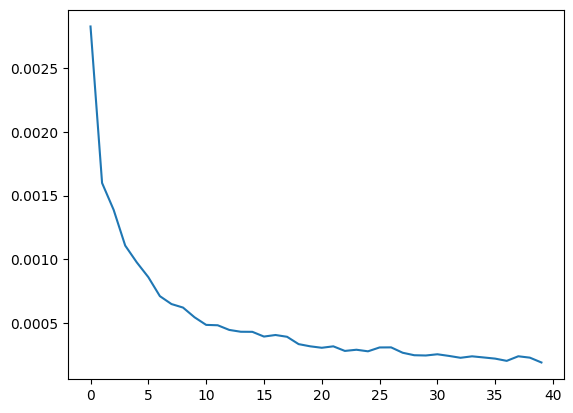

In [8]:
# Создание и обучение модели LSTM
model = Sequential()  # Создание последовательной модели
model.add(LSTM(units=16, input_shape=(1, look_back)))  # Добавление слоя LSTM с 16 нейронами и размером входных данных (1, look_back)
model.add(Dense(1))  # Добавление выходного полносвязного слоя с одним нейроном
model.compile(loss='mean_squared_error', optimizer='adam')  # Компиляция модели с использованием среднеквадратичной функции потерь и оптимизатора Adam
history = model.fit(trainX, trainY, epochs=40, batch_size=32, verbose=2)  # Обучение модели на обучающем наборе данных в течение 40 эпох с размером батча 32 (изменение коэффициентов на каждые 32 элемента обучающей выборки)
plt.plot(history.history['loss'])  # Визуализация графика функции потерь
plt.show()

In [9]:
# Создание предсказаний
len_pred = look_back * 2  # Предсказание на 2 * look_back
trainPredict = model.predict(trainX)  # Получение предсказаний на обучающем наборе данных

# Инвертирование предсказаний
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

# Создание массива для визуализации предсказаний
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

607/607 [==============================] - 2s 2ms/step


In [10]:
# Предсказание на тестовом наборе данных
testPredict = []

# Первый отрезок для предсказания
temp = [np.reshape(testX[0], (testX[0].shape[0], 1, testX[0].shape[1]))]

for i in range(len_pred):
    # Убираем самый первый элемент из отрезка сигнала, по которому предсказываем,
    # и добавляем в конец предсказание
    pred = list(model.predict(temp[-1]))
    last = temp[-1][0][0][1:]
    testPredict.append(list(pred[0]))  # Записываем текущее предсказание в выходной вектор
    new = np.append(last, pred)
    new = [np.reshape(new, (1, 1, look_back))]
    temp += new

# Инвертирование предсказаний
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Создание массива для визуализации предсказаний
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len_pred, :] = testPredict


<class 'list'>
1/1 [==============================] - 0s 36ms/step


In [11]:
# Предсказание на тестовом наборе данных
tPredict = model.predict(testX)

# Инвертирование предсказаний
tPredict = scaler.inverse_transform(tPredict)

# Создание массива для визуализации предсказаний
tPredictPlot = np.empty_like(dataset)
tPredictPlot[:, :] = np.nan
tPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(tPredict), :] = tPredict


290/290 [==============================] - 1s 2ms/step


In [12]:
# Вычисление среднеквадратичной ошибки
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0][look_back:look_back+len_pred], testPredict[:,0]))
print('Test Score по предсказанному: %.2f RMSE' % (testScore))
tScore = np.sqrt(mean_squared_error(testY[0], tPredict[:,0]))
print('Test Score по test: %.2f RMSE' % (tScore))

Train Score: 13.04 RMSE
Test Score по предсказанному: 35.74 RMSE
Test Score по test: 10.89 RMSE


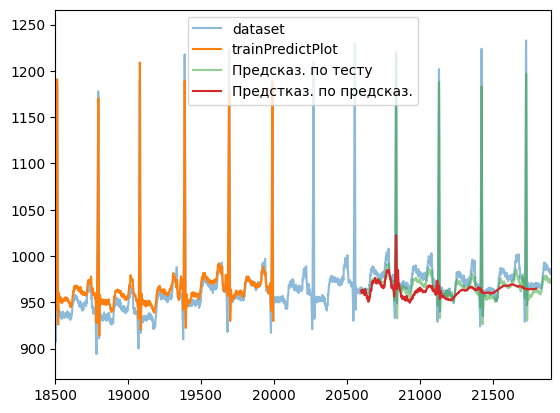

In [14]:
# Визуализация исходного сигнала, обучающего и тестового предсказания
plt.plot(scaler.inverse_transform(dataset), alpha=0.5, label='dataset')
plt.plot(trainPredictPlot, label='trainPredictPlot')
plt.plot(tPredictPlot, alpha=0.5, label='Предсказ. по тесту')
plt.plot(testPredictPlot, label='Предстказ. по предсказ.')

# Ограничение по x для лучшей видимости
plt.xlim([sets_len*0.67-1500, sets_len*0.67+look_back+len_pred+100])

# Отображение легенды
plt.legend()
plt.show()